In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# import os
import pandas as pd

# import pyro
# import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns

# import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log

# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler

# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmTraining as Train

print(torch.cuda.is_available())


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [2]:
enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc_ct = LabelEncoder()
enc_ct2 = LabelEncoder()


In [3]:
@curry
def binarize(x: torch.Tensor, threshold: float = 0.25) -> torch.Tensor:
    ret = (x > threshold).float()
    return ret


transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.MNIST(
    "data/",
    train=True,
    download=True,
    transform=transform,
)
test_dataset = datasets.MNIST(
    "data/",
    train=False,
    download=True,
    transform=transform,
)
train_data = train_dataset.data.float() / 255
test_data = test_dataset.data.float() / 255
train_labels = F.one_hot(
    train_dataset.targets.long(),
    num_classes=10,
).float()
test_labels = F.one_hot(
    test_dataset.targets.long(),
    num_classes=10,
).float()

data_loader = torch.utils.data.DataLoader(
    dataset=ut.SynteticDataSetV2(
        dati=[
            train_data,
            train_labels,
        ],
    ),
    batch_size=128,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=ut.SynteticDataSetV2(
        dati=[
            test_data,
            test_labels,
        ],
    ),
    batch_size=128,
    shuffle=True,
)

adata = sc.AnnData(
    X=train_data.detach().flatten(1).numpy(),
)
adata.obs["labels"] = train_dataset.targets.numpy().astype(str)
bdata = sc.AnnData(
    X=test_data.detach().flatten(1).numpy(),
)
bdata.obs["labels"] = test_dataset.targets.numpy().astype(str)


In [4]:
# semi supervised
subset = ut.randomSubset(s=len(train_labels), r=0.1)
labeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(
            data=train_data[subset],
            labels=train_labels[subset],
            ),
        batch_size=128,
        shuffle=True,
        )
unlabeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSet(
            data=train_data[subset == False],
            labels=train_labels[subset == False],
            ),
        batch_size=128,
        shuffle=True,
        )

In [18]:
reload(M15)
reload(M16)
reload(Train)
model = M16.VAE_Dirichlet_GMM_Type1602(
    nx=28**2,
    nclasses=10,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=32,
    nw=12,
    concentration=1e0,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.0,
    bn=False,
    yscale=1e0,
    #reclosstype="Bernoulli",
    relax=False,
    use_resnet=False,
    softargmax=True,
    restrict_w=True,
    restrict_z=True,
    do_cc=True,
    cc_radius=0.1,
)
model.apply(init_weights)
model = M16.VAE_GMM_Type1603(
    nx=28**2,
    nclasses=10,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=32,
    nw=12,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.0,
    bn=False,
    #reclosstype="Bernoulli",
    #reclosstype="mse",
    relax=False,
    use_resnet=False,
    #softargmax=True,
    do_cc=True,
    restrict_w=True,
    restrict_z=True,
    cc_radius=0.1,
    cc_scale = 5e0,
)
print()
model = M16.VAE_GMM_Type1603(
    nx=28**2,
    nclasses=10,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=32,
    nw=12,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    #yscale=0e0,
    yscale=1e1,
    zscale=5e0,
    wscale=5e0,
    #reclosstype="Bernoulli",
    reclosstype="mse",
    relax=False,
    use_resnet=False,
    #softargmax=True,
    do_cc=True,
    restrict_w=True,
    restrict_z=True,
    #cc_radius=0.01,
    cc_radius=2e-1,
    cc_scale = 5e0,
    bn=True,
    dropout=0.15,
)
print()

True
True
True




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch's lr =  0.001
epoch 0
training phase
rec: 218.48147583007812
loss_z: 40.49331283569336
loss_w: 6.867546558380127
loss_cluster: -0.17585834860801697
loss_y: 0.3129885196685791
loss_cc: 92.6657485961914
total_loss: 358.8210754394531
num_clusters: 0



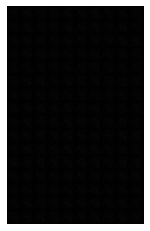

[ 7. -1.  2.  2.  7. -1.  3.  3.  9. -1.] 
 0.03212506970751687 
 [ 1.         -1.          0.29411765  0.2173913   1.         -1.
  0.26086957  0.28571429  0.26315789 -1.        ]
0.312 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 7
training phase
rec: 39.57151794433594
loss_z: 2.8727877140045166
loss_w: 0.02501576766371727
loss_cluster: -0.9901165962219238
loss_y: 0.4262728989124298
loss_cc: 0.001787690445780754
total_loss: 42.89738464355469
num_clusters: 10



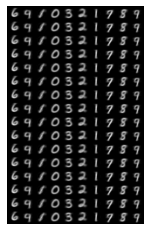

[6. 9. 1. 0. 3. 2. 1. 7. 8. 4.] 
 0.6414652014652015 
 [0.78571429 0.38461538 0.35714286 0.9        0.66666667 0.83333333
 0.83333333 0.69230769 0.5        0.46153846]
0.625 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 14
training phase
rec: 38.02577209472656
loss_z: 3.3071441650390625
loss_w: 0.03253624215722084
loss_cluster: -0.9918801188468933
loss_y: 0.10296253859996796
loss_cc: 1.8131772472340657e-10
total_loss: 41.468414306640625
num_clusters: 10



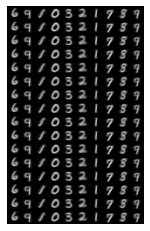

[6. 4. 8. 0. 3. 2. 1. 7. 8. 9.] 
 0.6243424630924631 
 [0.77777778 0.375      0.30769231 0.92857143 0.5        0.83333333
 0.9375     0.54545455 0.57142857 0.46666667]
0.6484375 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 21
training phase
rec: 36.93825149536133
loss_z: 3.8479299545288086
loss_w: 0.014805065467953682
loss_cluster: -0.9894871711730957
loss_y: 0.08039794862270355
loss_cc: 9.587778571074068e-09
total_loss: 40.881385803222656
num_clusters: 10



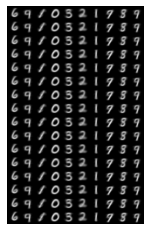

[6. 9. 1. 0. 3. 2. 1. 7. 2. 7.] 
 0.6627039627039627 
 [0.92857143 0.53846154 0.33333333 1.         0.71428571 0.92857143
 0.84615385 0.54545455 0.42857143 0.36363636]
0.671875 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 28
training phase
rec: 35.7479362487793
loss_z: 3.954564094543457
loss_w: 0.01706854999065399
loss_cluster: -0.9999128580093384
loss_y: 0.15508610010147095
loss_cc: 3.0893375965040937e-13
total_loss: 39.87465286254883
num_clusters: 10



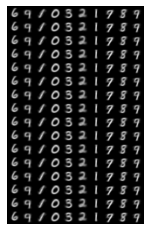

[6. 4. 1. 0. 3. 2. 1. 7. 8. 7.] 
 0.6510347985347985 
 [0.9375     0.53846154 0.4375     0.92307692 0.41666667 0.8
 1.         0.6        0.5        0.35714286]
0.6484375 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch's lr =  0.0001
epoch 0
training phase
rec: 36.68898010253906
loss_z: 2.993499279022217
loss_w: 0.01535201258957386
loss_cluster: -0.9999182224273682
loss_y: 0.2488919347524643
loss_cc: 8.335773737933039e-11
total_loss: 39.94672393798828
num_clusters: 10



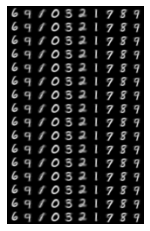

[6. 4. 1. 0. 5. 2. 1. 7. 8. 9.] 
 0.6730980130980131 
 [1.         0.45       0.4        1.         0.5        0.91666667
 0.88888889 0.69230769 0.45454545 0.42857143]
0.640625 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 7
training phase
rec: 36.90700912475586
loss_z: 2.285482406616211
loss_w: 0.0014600541908293962
loss_cluster: -0.9998283982276917
loss_y: 0.4320460557937622
loss_cc: 5.020784215048479e-07
total_loss: 39.62599563598633
num_clusters: 10



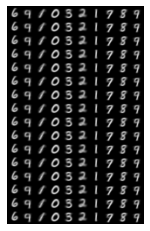

[6. 4. 1. 0. 5. 2. 1. 7. 8. 9.] 
 0.6232855706385119 
 [1.         0.30769231 0.5        1.         0.35294118 0.88888889
 0.86666667 0.4        0.5        0.41666667]
0.578125 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 14
training phase
rec: 37.126007080078125
loss_z: 2.372337818145752
loss_w: 0.0020045728888362646
loss_cluster: -0.9999897480010986
loss_y: 0.30213648080825806
loss_cc: 3.7136222916234196e-13
total_loss: 39.80248260498047
num_clusters: 10



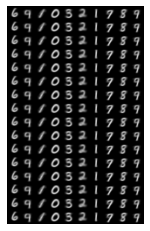

[6. 4. 1. 0. 3. 2. 1. 7. 5. 9.] 
 0.6125009794127441 
 [0.66666667 0.375      0.33333333 0.92857143 0.66666667 0.75
 1.         0.53846154 0.41176471 0.45454545]
0.578125 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 21
training phase
rec: 36.54996109008789
loss_z: 2.4007458686828613
loss_w: 0.0011780811473727226
loss_cluster: -0.9999994039535522
loss_y: 0.2482789158821106
loss_cc: 8.731322088950666e-12
total_loss: 39.200164794921875
num_clusters: 10



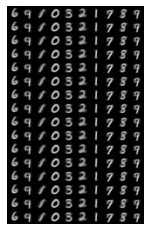

[6. 4. 5. 0. 3. 2. 1. 7. 8. 7.] 
 0.6957905982905983 
 [0.93333333 0.5        0.30769231 1.         0.53846154 1.
 1.         0.69230769 0.61111111 0.375     ]
0.6953125 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 28
training phase
rec: 34.8912353515625
loss_z: 2.8995139598846436
loss_w: 0.002930185291916132
loss_cluster: -0.9996071457862854
loss_y: 0.356503963470459
loss_cc: 1.8828318454854314e-15
total_loss: 38.15018081665039
num_clusters: 10



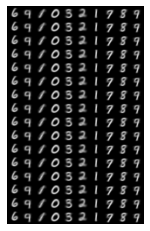

[6. 9. 1. 0. 3. 2. 1. 9. 8. 7.] 
 0.6821118012422359 
 [1.         0.4        0.85714286 1.         0.47826087 0.86666667
 0.83333333 0.42857143 0.6        0.35714286]
0.6640625 

done training


<Figure size 432x288 with 0 Axes>

In [19]:
Train.basicTrainLoop(
    model,
    data_loader,
    None,
    num_epochs=30,
    #lrs=[1e-5,1e-4,1e-3,1e-3,1e-4,1e-5],
    #lrs=[1e-4,1e-3,1e-4,1e-5],
    lrs=[1e-3,1e-4,],
    wt=1e-5,
    report_interval=7,
    do_plot=True,
    test_accuracy=True,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch's lr =  0.001
epoch 0
training phase
rec: 36.72083282470703
loss_z: 3.522724151611328
loss_w: 0.0010201497934758663
loss_cluster: -0.999603271484375
loss_y: 0.28130343556404114
loss_cc: 7.368374573685221e-13
total_loss: 40.52587890625
num_clusters: 10



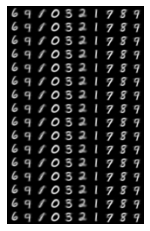

[6. 9. 1. 0. 3. 2. 1. 7. 8. 9.] 
 0.6073215183509302 
 [0.75       0.375      0.30769231 1.         0.44444444 0.91666667
 0.875      0.52941176 0.4375     0.4375    ]
0.578125 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 17
training phase
rec: 37.33619689941406
loss_z: 3.4942245483398438
loss_w: 0.03217221051454544
loss_cluster: -0.999055027961731
loss_y: 0.6976772546768188
loss_cc: 3.954205018974477e-11
total_loss: 41.560272216796875
num_clusters: 10



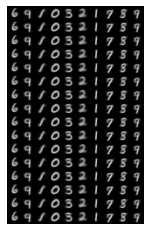

[6. 9. 1. 0. 3. 2. 1. 7. 8. 4.] 
 0.6960353535353535 
 [0.81818182 0.625      0.45454545 0.81818182 0.75       0.94444444
 1.         0.5        0.55       0.5       ]
0.671875 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch's lr =  0.0001
epoch 0
training phase
rec: 38.449012756347656
loss_z: 2.6551308631896973
loss_w: 0.005602069199085236
loss_cluster: -0.999026894569397
loss_y: 0.2672162353992462
loss_cc: 2.335752305546862e-13
total_loss: 41.3769645690918
num_clusters: 10



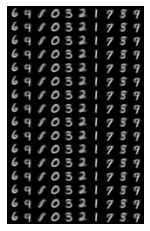

[6. 4. 1. 0. 3. 2. 1. 7. 8. 9.] 
 0.6293711843711843 
 [0.91666667 0.42857143 0.2        1.         0.45454545 0.92307692
 0.77777778 0.66666667 0.38095238 0.54545455]
0.6015625 



KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [20]:
model.cc_radius = 0.5
Train.basicTrainLoop(
    model,
    data_loader,
    None,
    num_epochs=30,
    #lrs=[1e-5,1e-4,1e-3,1e-3,1e-4,1e-5],
    lrs=[1e-3,1e-4,1e-5],
    wt=1e-5,
    report_interval=17,
    do_plot=True,
    test_accuracy=True,
)

In [10]:
ut.estimateClusterImpurityLoop(
        model, test_data, test_labels, "cpu",
        )

r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(p, "\n", r.mean(), "\n", r)
print((r*s).sum() / s.sum())


[3. 5. 9. 4. 0. 2. 8. 6. 1. 7.] 
 0.7464431048563401 
 [0.65393989 0.61730013 0.44787234 0.61562179 0.97266036 0.79852806
 0.6642269  0.97004608 0.99354244 0.73069307]
0.7472


In [13]:
model.cc_scale
model.cc_radius

0.1

In [5]:
#best ever
model = M10.VAE_Dirichlet_Type1004R(
        nx=28**2,
        nh=1024,
        nw=32,
        nz=64,
        nclasses=10,
        #concentration=1.5e-0,
        concentration=1.0e-0,
        numhidden=2,
        dropout=0.3,
        reclosstype="Bernoulli",
        bn=True,
        )
model.apply(init_weights)
model = M16.VAE_Dirichlet_GMM_Type1602(
    nx=28**2,
    nclasses=10,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    concentration=2.5e1,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.3,
    bn=True,
    yscale=1e0,
    reclosstype="Bernoulli",
    relax=False,
    use_resnet=True,
    restrict_w=True,
    restrict_z=True,
    do_cc=True,
    cc_radius=0.1,
)
model.apply(init_weights)
model = M16.VAE_GMM_Type1603(
    nx=28**2,
    nclasses=10,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.3,
    bn=True,
    yscale=1e1,
    zscale=2e0,
    wscale=2e0,
    reclosstype="Bernoulli",
    relax=False,
    use_resnet=True,
    #restrict_w=True,
    #restrict_z=True,
    #do_cc=True,
    #cc_radius=0.1,
)
model.apply(init_weights)

print()

epoch's lr =  0.0001
epoch 0
training phase
rec: 597.0746459960938
loss_z: 71.22847747802734
loss_w: 20.349525451660156
loss_cluster: -0.25511786341667175
loss_y: 0.09962598234415054
loss_cc: 186.703857421875
total_loss: 875.4561157226562
num_clusters: 2



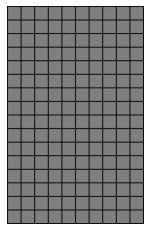

[-1. -1. -1. -1. -1. -1.  1. -1. -1. -1.] 
 -0.88671875 
 [-1.        -1.        -1.        -1.        -1.        -1.
  0.1328125 -1.        -1.        -1.       ]
0.2184873949579832 

epoch's lr =  0.0001
epoch 0
training phase
rec: 131.4667205810547
loss_z: 13.723515510559082
loss_w: 2.9037046432495117
loss_cluster: -0.9952048063278198
loss_y: 1.6200463771820068
loss_cc: 1.0067683433589991e-05
total_loss: 149.7139892578125
num_clusters: 2



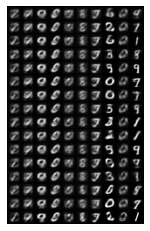

[-1. -1. -1. -1. -1. -1. -1.  0. -1.  8.] 
 -0.7478824546240277 
 [-1.         -1.         -1.         -1.         -1.         -1.
 -1.          0.30769231 -1.          0.21348315]
0.325 

epoch's lr =  0.001
epoch 0
training phase
rec: 103.0973129272461
loss_z: 13.399612426757812
loss_w: 5.562591552734375
loss_cluster: -1.0
loss_y: 1.6095600128173828
loss_cc: 9.075981506612152e-05
total_loss: 123.6691665649414
num_clusters: 2



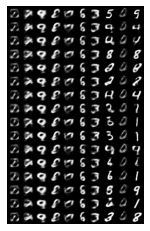

[-1. -1.  4. -1. -1. -1. -1.  2. -1. -1.] 
 -0.763246425567704 
 [-1.         -1.          0.17241379 -1.         -1.         -1.
 -1.          0.19512195 -1.         -1.        ]
0.25833333333333336 

done training


<Figure size 432x288 with 0 Axes>

In [6]:
Train.basicTrainLoop(
    model,
    data_loader,
    None,
    num_epochs=5,
    #lrs=[1e-5,1e-4,1e-3,1e-3,1e-4,1e-5],
    lrs=[1e-4,1e-4,1e-3],
    wt=1e-4,
    report_interval=10,
    do_plot=True,
    test_accuracy=True,
)
